# The first few blocks of code was covered previously

### Read the images and labels and store them into arrays

In [2]:
import os
import shutil
import numpy as np
from skimage import io
from PIL import Image

base_path = "kiran_crop"
new_all_path = os.path.join(base_path, "kiran_all_crop")
new_hem_path = os.path.join(base_path, "kiran_hem_crop")

In [3]:
# read Hem images from disk and store them in an array
hem_in_list=[]
hem_labels_in_list=[]

hem_images_paths = os.listdir(new_hem_path)
for i, image_name in enumerate(hem_images_paths):
    if(image_name.split('.')[1] == 'bmp'):
        image = io.imread(new_hem_path+'/'+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((125,125))
        hem_in_list.append(np.array(image))
        hem_labels_in_list.append("hem")
    
hem_in_array = np.array(hem_in_list)
hem_labels_in_array = np.array(hem_labels_in_list)

del hem_in_list
del hem_labels_in_list

In [4]:
np.amax(hem_in_array[168])

252

In [5]:
# read ALL images from disk and store them in an array
all_in_list=[]
all_labels_in_list=[]

all_images_paths = os.listdir(new_all_path)
for i, image_name in enumerate(all_images_paths):
    if(image_name.split('.')[1] == 'bmp'):
        image = io.imread(new_all_path+'/'+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((125,125))
        all_in_list.append(np.array(image))
        all_labels_in_list.append("all")

all_in_array = np.array(all_in_list)
all_labels_in_array = np.array(all_labels_in_list)

del all_in_list
del all_labels_in_list

In [6]:
np.amax(all_in_array[452])

117

# Moving on..

### Combine images and labels into single arrays

In [9]:
images = np.concatenate((all_in_array, hem_in_array), axis=0)
del all_in_array
del hem_in_array
labels = np.concatenate((all_labels_in_array, hem_labels_in_array), axis=0)
del all_labels_in_array
del hem_labels_in_array

In [10]:
#check labels
labels[6000], labels[9000]

('all', 'hem')

### Encode labels

In [11]:
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
labels = encoder.fit_transform(labels)

In [12]:
#check labels
labels[6000], labels[9000] #all=0, hem=1

(0, 1)

### Split the data

In [13]:
from sklearn.model_selection import train_test_split

#split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=42)

In [14]:
#confirming images are still in proper shape


## Scaling images

In [15]:
#before scaling
np.amax(x_train[7000])

113

In [16]:
#display image before scaling

In [17]:
#scaling
x_train = x_train/255
x_test = x_test/255

In [18]:
#after scaling
np.amax(x_train[7000])

0.44313725490196076

In [19]:
#display image after scaling

# Transfer Learning

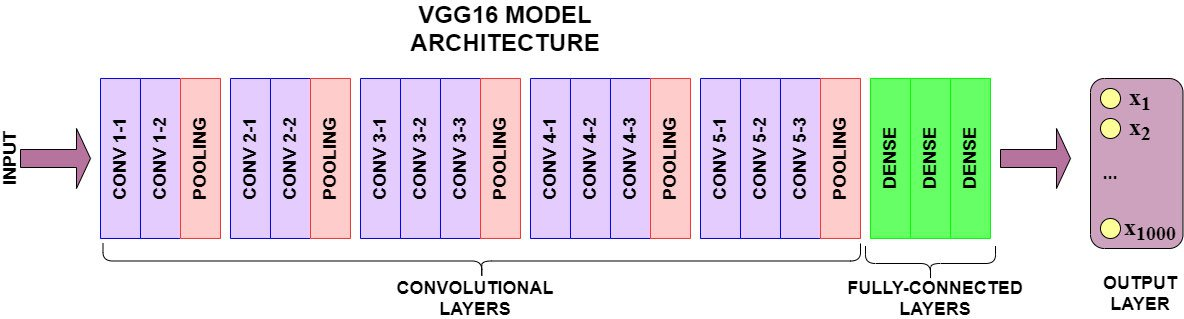

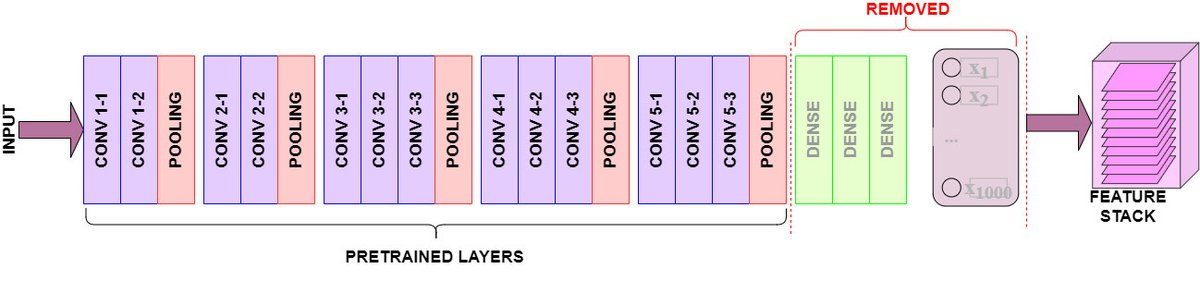

In [20]:
from tensorflow.keras.applications.vgg16 import VGG16

VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(125,125,3))

In [21]:
for layer in VGG_model.layers:
    layer.trainable=False
    
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 125, 125, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 125, 125, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 125, 125, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 62, 62, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 62, 62, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 62, 62, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 31, 31, 128)       0     

## Extracting Features

In [22]:
x_train_feats = VGG_model.predict(x_train)
x_train_features = x_train_feats.reshape(x_train_feats.shape[0], -1)

x_test_feats = VGG_model.predict(x_test)
x_test_features = x_test_feats.reshape(x_test_feats.shape[0], -1) 

92/92 [==============================] - 151s 2s/step


In [23]:
x_test_feats.shape

(2913, 3, 3, 512)

In [24]:
x_test_features.shape

(2913, 4608)

In [25]:
3*3*512

4608

## Storing extracted features in pandas dataframe

In [26]:
import pandas as pd

# Convert the feature vectors to Pandas DataFrames
train_df = pd.DataFrame(x_train_features)
test_df = pd.DataFrame(x_test_features)

In [27]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4598,4599,4600,4601,4602,4603,4604,4605,4606,4607
0,0.000000,0.0,0.335362,0.191588,0.111455,0.0,0.0,0.000000,0.0,0.233555,...,0.815600,0.000000,0.000000,0.0,0.000000,0.336870,0.0,0.0,0.280540,0.0
1,0.058480,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,1.666007,0.835123,0.320351,0.0,0.395172,0.000000,0.0,0.0,0.000000,0.0
2,0.282112,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.068944,0.0,0.000000,...,1.876584,0.715905,0.171945,0.0,0.000000,0.308108,0.0,0.0,0.079297,0.0
3,0.387874,0.0,0.000000,0.050626,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,1.401104,0.576575,0.180843,0.0,0.027337,0.151989,0.0,0.0,0.175057,0.0
4,0.141062,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,2.013519,0.851573,0.096842,0.0,0.032068,0.478181,0.0,0.0,0.115065,0.0


In [28]:
# Add the labels to the DataFrames
train_df['label'] = y_train
test_df['label'] = y_test

In [29]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.000000,0.0,0.335362,0.191588,0.111455,0.0,0.0,0.000000,0.0,0.233555,...,0.000000,0.000000,0.0,0.000000,0.336870,0.0,0.0,0.280540,0.0,1
1,0.058480,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.835123,0.320351,0.0,0.395172,0.000000,0.0,0.0,0.000000,0.0,0
2,0.282112,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.068944,0.0,0.000000,...,0.715905,0.171945,0.0,0.000000,0.308108,0.0,0.0,0.079297,0.0,0
3,0.387874,0.0,0.000000,0.050626,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.576575,0.180843,0.0,0.027337,0.151989,0.0,0.0,0.175057,0.0,0
4,0.141062,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.851573,0.096842,0.0,0.032068,0.478181,0.0,0.0,0.115065,0.0,1


In [30]:
#11649 rows × 2048 columns

# Save the dataframes to disk

In [31]:
import pickle

with open('train_data.pickle', 'wb') as f:
    pickle.dump(train_df, f)
    
with open('test_data.pickle', 'wb') as f:
    pickle.dump(test_df, f)

In [32]:
with open('train_data.pickle', 'rb') as f:
    train_df_new = pickle.load(f)